In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pynwb as nwb
from pynwb import NWBHDF5IO
import pandas as pd
from scipy.signal import gaussian, convolve

In [2]:
def read_mc_maze(data_path):
    data = NWBHDF5IO(data_path, "r").read()
    D = pd.DataFrame({('cursor_pos', 'x'):data.processing['behavior']['cursor_pos'].data[:,0],
                        ('cursor_pos', 'y'):data.processing['behavior']['cursor_pos'].data[:,1], 
                        ('eye_pos', 'x'):data.processing['behavior']['eye_pos'].data[:,0],
                        ('eye_pos', 'y'):data.processing['behavior']['eye_pos'].data[:,1], 
                        ('hand_pos', 'x'):data.processing['behavior']['hand_pos'].data[:,0],
                        ('hand_pos', 'y'):data.processing['behavior']['hand_pos'].data[:,1],  
                        ('hand_vel', 'x'):data.processing['behavior']['hand_vel'].data[:,0],
                        ('hand_vel', 'y'):data.processing['behavior']['hand_vel'].data[:,1], 
        })
    trial_info = data.trials.to_dataframe()
    units = data.units.to_dataframe()
    units = units.drop(labels='obs_intervals', axis=1)
    units['location'] = [units.loc[unit, 'electrodes']['location'].iloc[0] for unit in units.axes[0]]
    units = units.drop(labels='electrodes', axis=1)

    trial_info = trial_info[trial_info['stop_time'] <= len(D)/1000]
    
    return D, trial_info, units

data_path = "./000128/sub-Jenkins/sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb"
D, trial_info, units = read_mc_maze(data_path)

In [3]:
class Analysis_tools():
    """ Class for tools often required for data analysis
    """
    def __init__(self, fs):
        self.fs = fs

    def get_stem(self, units, which_unit, t,  **kwargs):
        """ Get spike times for a specific unit, during a specific time
        """
        self.dt = kwargs.get('dt', 1/1000)   # Step size 
        self.t_pad = kwargs.get('t_pad', 0.5)   # How many seconds to pad the data from before and after the trial 
        plot = kwargs.get('plot', False)   # Plot the single trial
        return_padded = kwargs.get('return_padded', False)   # Whether to returned  


        t_low = max(0.0, t[0] - self.t_pad)
        t_high = min(t[1] + self.t_pad, len(D)/self.fs/60)
        t_trial = int(np.round((t_high - t_low)/self.dt))
        spike_times = units.loc[which_unit,:]['spike_times']
        in_range_inx = (spike_times <= t_high) & (spike_times >= t_low)
        in_range_time = spike_times[in_range_inx]
        in_range_time_idx = np.round((in_range_time - t_low) / self.dt).astype('int')

        # Temp zero for continuous rate
        stem = np.zeros((t_trial, ), dtype='bool')
        stem[in_range_time_idx] = 1

        if return_padded == 0:
            num_pad = np.round(self.t_pad/ self.dt).astype('int')
            stem = stem[num_pad:-1-num_pad]

        # Plot single trial
        if plot:
            plt.plot(stem, c='k')
            plt.xlabel('Time (ms)')
            plt.gca().set_yticks([])

        return stem
    
    def get_fr(self, units, which_unit, t, **kwargs):
        """ Get firing rate for a specific unit, during a specific time
        """
        self.gauss_width = kwargs.get('gauss_width', 50)   # Window size 50 ms
        self.dt = kwargs.get('dt', 1/1000)   # Step size 
        self.t_pad = kwargs.get('t_pad', 0.5)   # How many seconds to pad the data from before and after the trial 
        plot = kwargs.get('plot', False)   # Plot the single trial
        return_padded = kwargs.get('return_padded', False)   # Whether to returned  

        # Get the stem first
        stem = self.get_stem(units, which_unit, t, plot=False, dt=self.dt, t_pad=self.t_pad, return_padded=True)
        # Smooth the stem with Gaussian window
        # Compute Gauss window and std with respect to bins
        bin_width = self.dt * self.fs

        gauss_bin_std = self.gauss_width / bin_width
        # the window extends 3 x std in either direction
        win_len = int(6 * gauss_bin_std)
        # Create Gaussian kernel
        window = gaussian(win_len, gauss_bin_std, sym=True)
        window /=  np.sum(window)
        FR = convolve(stem, window, 'same') / self.dt

        if return_padded == 0:
            num_pad = np.round(self.t_pad/ self.dt).astype('int')
            FR = FR[num_pad:-1-num_pad]

        if plot:
            plt.plot(FR, c='k')
            plt.xlabel('Time (ms)')
            plt.ylabel('Firing rate (Spk/s)')

        return FR
        


tools = Analysis_tools(fs = 1000)

array([7.71407624, 7.75429391, 7.791604  , ..., 0.        , 0.        ,
       0.        ])

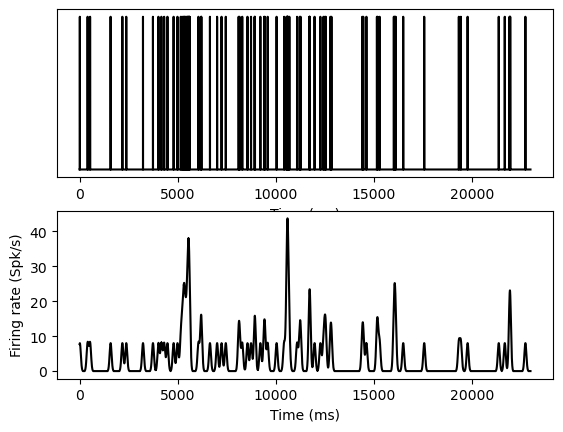

In [4]:
which_unit = 2561
t = [90, 150]

t_pad = 0.5 # Seconds
dt = 1/1000

plt.subplot(2,1,1)
tools.get_stem(units, which_unit, t, plot=True, dt=dt, t_pad=t_pad)
plt.subplot(2,1,2)
tools.get_fr(units, which_unit, t, plot=True, dt=dt, t_pad=t_pad)

In [5]:
condition_columns = ['trial_type', 'trial_version']
align_column = 'move_onset_time'
channel_column = 'hand_pos'
conds = trial_info.set_index(condition_columns).index.unique().tolist()
t_range = [-50, 450]
# Zero tensor for mean data (Condition x Time x channel)
data_aligned = np.zeros((len(conds),t_range[1] - t_range[0], len(D[channel_column].columns)))

In [19]:

for cond_i, cond in enumerate(conds):
    # Make a mask to select desired trials
    mask = np.all(trial_info[condition_columns] == cond, axis=1)
    mask_idx = np.where(mask)[0]
    # Get start time, end time and event time for each condition
    # Start and end time in absolute time 
    start_times = trial_info.loc[mask_idx].start_time.to_numpy()
    end_times = trial_info.loc[mask_idx].stop_time.to_numpy()
    # event code time reletive to trial start
    event_times = trial_info.loc[mask_idx][align_column].to_numpy() - start_times

    data_temp = np.zeros((len(start_times) ,t_range[1] - t_range[0], len(D[channel_column].columns)))
    # Loop over trials of the same conditioin
    for i, (ts, tev, te) in enumerate(zip(start_times, event_times, end_times)):
        temp = D[channel_column].iloc[int(ts*1000):int(te*1000), :].to_numpy()
        t_event = int(tev*1000)
        data_temp[i, :, :] = temp[t_event+t_range[0]:t_event+t_range[1], :]

    data_aligned[cond_i, :, :] = np.mean(data_temp, axis=0)

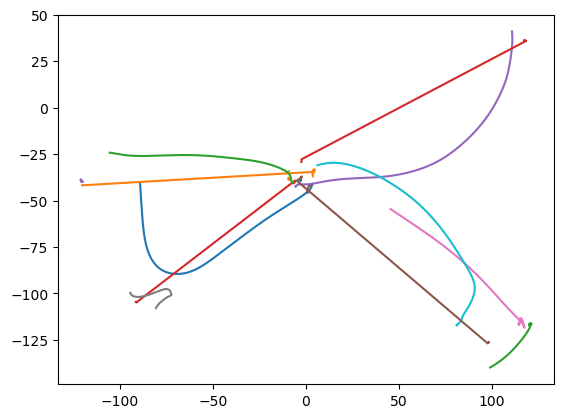

In [18]:
for tr in range(data_temp.shape[0]):
    plt.plot(data_temp[tr, : ,0], data_temp[tr, : ,1])

In [14]:
trial_info.loc[mask_idx].stop_time.to_numpy()

array([2263.401, 2276.961, 2593.001, 2822.816, 2912.496, 3288.791,
       3349.781, 3539.501, 3783.731, 3973.516, 4542.326, 4931.261,
       5214.306, 5875.756, 6354.496, 6406.281])

In [ ]:
plt.plot(D[channel_column].iloc[int(ts*1000):int(te*1000), 0], D[channel_column].iloc[int(ts*1000):int(te*1000), 1])

In [ ]:
for i in range(data_temp.shape[0]):
    plt.plot(data_temp[i, :, 0], data_temp[i, :, 1])

In [ ]:
for cond in range(data_aligned.shape[0]):
    plt.plot(data_aligned[cond, :, 0], data_aligned[cond, :, 1])